In [1]:
import os
import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.reset_default_graph()

In [2]:
import warnings
import os
from tensorflow.keras.backend import set_session
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True
# to log device placement (on which device the operation ran)
config.log_device_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
# (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.InteractiveSession(config=config)
# set this TensorFlow session as the default session for Keras
#set_session(sess)



In [3]:
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 128
NUM_CLASSES = 2

# data generator

In [5]:
class Barkley_Deep_Drive(object):
    
    def __init__(self, tfrecord_path):
        self.dataset = tf.data.TFRecordDataset(tfrecord_path)
        
    @staticmethod
    def normalize(image, label):
        """Convert `image` from [0, 255] -> [-0.5, 0.5] floats."""
        image = tf.cast(image, tf.float32) * (1. / 255)
        return image, label
        
    @staticmethod
    def decode(serialized_example):
        """
        Parses an image and label from the given `serialized_example`.
        It is used as a map function for `dataset.map`
        """
        IMAGE_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)

        # 1. define a parser
        features = tf.parse_single_example(
            serialized_example,
            # Defaults are not specified since both keys are required.
            features={
                'image': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.string),
            })

        # 2. Convert the data
        image = tf.decode_raw(features['image'], tf.float32)
        label = features['label']

        # 3. reshape
        image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))

        return image, label
    
    def get_batch(self, batch_size = 32, shuffle = True, num_threads = -1, buffer_size=4096):
        
        self.dataset = self.dataset.map(self.decode, num_parallel_calls=num_threads)
        
        if shuffle:
            self.dataset = self.dataset.shuffle(buffer_size)
            
        self.dataset = self.dataset.map(self.normalize)
        self.dataset = self.dataset.batch(batch_size, drop_remainder=True)
        
        iterator = self.dataset.make_one_shot_iterator()
        
        #TO DO: return this
        #image_iterator, label_iterator = iterator.get_next()

        return iterator
        

# Network

In [6]:
def discriminator(input_var, name='D_discriminator', reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        # Five intermediate blocks : conv + layer norm + instance norm + leaky relu
        for i in range(num_blocks):
            conv = tf.layers.conv2d(inputs = input_var,
                                    filters = filters, 
                                    kernel_size = kernel_size,
                                    padding = 'valid', 
                                    strides = strides)
            layer_norm = tf.contrib.layers.layer_norm(conv)
            instance_norm = tf.contrib.layers.instance_norm(layer_norm)
            leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)

            input_var = leaky_relu_out
            filters += filters
            
        
        # Output block : fc(1024) + layer norm + instance norm + leaky relu
        output_blocks = input_var
        
        fc = tf.contrib.layers.fully_connected(output_blocks, num_outputs = 1024)
        layer_norm = tf.contrib.layers.layer_norm(fc)
        instance_norm = tf.contrib.layers.instance_norm(layer_norm)
        leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)
        # Output
        output = tf.contrib.layers.flatten(leaky_relu_out)
        output = tf.contrib.layers.fully_connected(output, num_outputs = 1)
        
        return output

In [7]:
def classifier(input_var, name='C_classifier', reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        # Five intermediate blocks : conv + layer norm + instance norm + leaky relu
        for i in range(num_blocks):
            conv = tf.layers.conv2d(inputs = input_var,
                                    filters = filters, 
                                    kernel_size = kernel_size,
                                    padding = 'SAME', 
                                    strides = strides)
            layer_norm = tf.contrib.layers.layer_norm(conv)
            instance_norm = tf.contrib.layers.instance_norm(layer_norm)
            leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)

            input_var = leaky_relu_out
            filters += filters

        # Output block : fc(1024) + layer norm + instance norm + leaky relu
        output_blocks = input_var
        fc = tf.contrib.layers.fully_connected(output_blocks, 
                                               num_outputs = 1024)
        layer_norm = tf.contrib.layers.layer_norm(fc)
        instance_norm = tf.contrib.layers.instance_norm(layer_norm)
        leaky_relu_out = tf.nn.leaky_relu(instance_norm, alpha = leakyrelu_alpha)
        # Output
        output = tf.contrib.layers.flatten(leaky_relu_out)
        out = tf.contrib.layers.fully_connected(output,
                                                num_outputs=2)
        return tf.nn.sigmoid(out)

In [8]:
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d", padding = 'SAME'):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
        
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding=padding)
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))

        return tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    
def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))


        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        
        return tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())


    
def encoder(inputs, name = 'G_encoder', reuse=tf.AUTO_REUSE, is_training = True):
    """
    encoder function
    :param: inputs
    :param: name
    :return list of layers:
    """

    with tf.variable_scope(name, reuse=reuse):
        
        leakyrelu_alpha = 0.2
        num_blocks = 5
        filters = 64
        kernel_size = 4
        strides = 2
        
        layers = []
        layers.append(inputs)
        
        for i in range(num_blocks):
            conv = conv2d(inputs, filters, kernel_size, kernel_size, strides, strides, name = str(i+1))
            batch_norm = tf.contrib.layers.batch_norm(conv)
            leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha)
            
            inputs = leaky_relu
            filters += filters
            layers.append(inputs)
            
        return layers
    
def decoder(inputs, label, name = 'G_decoder', reuse=None, is_training = True):
    """
    decoder function
    :param: inputs (list of layers from encoder)
    :param: name
    :return tanh(conv5):
    """
    leakyrelu_alpha = 0.2
    filters = 1024
    kernel_size = 4
    strides = 2
    
    input_ = inputs[-1]

    def _attribute_concat(label, z):
        label = tf.expand_dims(label, 1)
        label = tf.expand_dims(label, 1)
        #label = label[:,tf.newaxis, tf.newaxis,:] #or use expand_dims twice
        label = tf.tile(label, [1, *z.get_shape().as_list()[1:3], 1])
        label = tf.cast(label, dtype=tf.float32)
        label = tf.concat([z, label], axis=3)
        return label
    
    input_ = _attribute_concat(label, input_)
    
    with tf.variable_scope(name, reuse=reuse):
                
        for ind in list(reversed(range(len(inputs)))):
            outout_shape = inputs[ind-1].get_shape().as_list()
            
            if ind==1:
                deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = "deconv_{}".format(ind))
                return tf.nn.tanh(deconv)
            
            deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = str(ind-1))
            concatenated = tf.concat([deconv, inputs[ind-1]], axis=3)

            batch_norm = tf.contrib.layers.batch_norm(concatenated)
            
            input_ = leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha, name = "ReLU_{}".format(ind))

In [ ]:
image_batch

In [ ]:
conv = conv2d(inputs, filters, kernel_size, kernel_size, strides, strides, name = str(i+1))

# data input

In [9]:
training_data = Barkley_Deep_Drive('../resources/train.tfrecords')
validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')

iterator = validation_data.get_batch(BATCH_SIZE, shuffle = False)
image_iterator, label_iterator = iterator.get_next()
image_batch, label_batch = sess.run([image_iterator, label_iterator])


W1127 12:52:00.621103 140522835531584 deprecation.py:323] From <ipython-input-5-784b5d784e05>:48: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


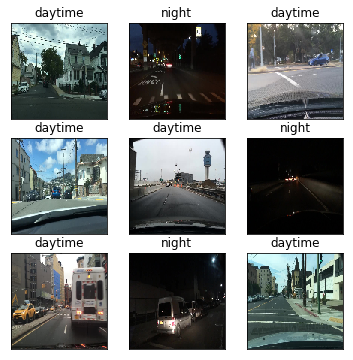

In [10]:
#number_of_images = np.int(np.floor(np.sqrt(BATCH_SIZE)))
number_of_images = 3

plt.figure(1, figsize=(number_of_images*2,number_of_images*2))
for ind, i in enumerate(range(number_of_images**2)):
    plt.subplot(number_of_images,number_of_images,i+1)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].decode("utf-8"))

# Loss definitions

<img src="../docs/architecture.png" style="height:500px"> 

In [11]:
xa = tf.placeholder(tf.float32,shape=[BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3],name="xa") #orignal image
z = encoder(xa, reuse=tf.AUTO_REUSE) #encoder output

a = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="a") #original attributes
b = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="b") #desired attributes

xb_hat = decoder(z, b, reuse=tf.AUTO_REUSE) #decoder output
#with tf.control_dependencies([xb_hat]):
xa_hat = decoder(z, a, reuse=tf.AUTO_REUSE) #decoder output

xa_logit_D = discriminator(xa, reuse=tf.AUTO_REUSE) # Discriminator output -- gan
xa_logit_C = classifier(xa, reuse=tf.AUTO_REUSE) # Classifier output -- attribute

xb_logit_D = discriminator(xb_hat, reuse=tf.AUTO_REUSE) # Discriminator output -- gan
xb_logit_C = classifier(xb_hat, reuse=tf.AUTO_REUSE) # Classifier output -- attribute basically b_hat

W1127 12:52:02.519341 140522835531584 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1127 12:52:03.146409 140522835531584 deprecation.py:323] From <ipython-input-6-e90d8ceb9ee9>:14: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1127 12:52:03.149521 140522835531584 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future ver

In [12]:
def gradient_penalty(func, a, b):
    """
    :param: discriminator (function)
    :a: xa (tensor)
    :b: xb_hat (tensor)
    :return gp: gradient penalty
    """
    with tf.name_scope('interpolate'):
        alpha = tf.random_uniform(shape=a.shape, minval=0., maxval=1.)
        inter = a + alpha * (b - a)
    with tf.name_scope('gradient_penalty'):
        pred = func(inter, reuse=tf.AUTO_REUSE)
        grad = tf.gradients(pred, inter)[0]
        norm = tf.norm(tf.contrib.slim.flatten(grad), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)
        return gp

# discriminator losses

In [13]:
lambda_ = {"3" : 1, "2" : 10, "1" : 100}

In [14]:
#losses
loss_adv_D =  - ( tf.reduce_mean(xa_logit_D) - tf.reduce_mean(xb_logit_D) )

gp = gradient_penalty(discriminator, xa, xb_hat)

loss_cls_C = tf.losses.sigmoid_cross_entropy(a, xa_logit_C)
 
D_loss = gp * lambda_['3'] * loss_cls_C + loss_adv_D

W1127 12:52:06.149676 140522835531584 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# generator lossses

In [15]:
loss_adv_G = -tf.reduce_mean(xb_logit_D)

#loss_cls_G = tf.nn.sigmoid_cross_entropy_with_logits(labels = b, logits = xb_logit_C)
loss_cls_G = tf.losses.sigmoid_cross_entropy(b, xb_logit_C)

loss_rec = tf.losses.absolute_difference(xa, xa_hat)

G_loss =  lambda_['1'] * loss_rec + lambda_['2'] * loss_cls_G + loss_adv_G

In [16]:
LEARNING_RATE = 0.002
BETA_1 = 0.5
BETA_2 = 0.999

In [17]:
""" Training """
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'C_' in var.name or 'D_' in var.name]
g_vars = [var for var in t_vars if 'G_' in var.name]
assert(len(t_vars) == len(d_vars ) + len(g_vars )), "mismatch in variable names"


In [18]:
d_optim = tf.train.AdamOptimizer(learning_rate = BETA_1,
                                 beta1 = BETA_1,
                                 beta2 = BETA_2).minimize(D_loss, var_list=d_vars)

g_optim = tf.train.AdamOptimizer(learning_rate = BETA_1,
                                 beta1 = BETA_1,
                                 beta2 = BETA_2).minimize(G_loss, var_list=g_vars)


# Training

In [19]:
def summary(tensor_collection,
            summary_type=['mean', 'stddev', 'max', 'min', 'sparsity', 'histogram'],
            scope=None):
    """Summary.

    usage:
        1. summary(tensor)
        2. summary([tensor_a, tensor_b])
        3. summary({tensor_a: 'a', tensor_b: 'b})
    """
    def _summary(tensor, name, summary_type):
        """Attach a lot of summaries to a Tensor."""
        if name is None:
            # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
            # session. This helps the clarity of presentation on tensorboard.
            name = re.sub('%s_[0-9]*/' % 'tower', '', tensor.name)
            name = re.sub(':', '-', name)

        summaries = []
        if len(tensor.shape) == 0:
            summaries.append(tf.summary.scalar(name, tensor))
        else:
            if 'mean' in summary_type:
                mean = tf.reduce_mean(tensor)
                summaries.append(tf.summary.scalar(name + '/mean', mean))
            if 'stddev' in summary_type:
                mean = tf.reduce_mean(tensor)
                stddev = tf.sqrt(tf.reduce_mean(tf.square(tensor - mean)))
                summaries.append(tf.summary.scalar(name + '/stddev', stddev))
            if 'max' in summary_type:
                summaries.append(tf.summary.scalar(name + '/max', tf.reduce_max(tensor)))
            if 'min' in summary_type:
                summaries.append(tf.summary.scalar(name + '/min', tf.reduce_min(tensor)))
            if 'sparsity' in summary_type:
                summaries.append(tf.summary.scalar(name + '/sparsity', tf.nn.zero_fraction(tensor)))
            if 'histogram' in summary_type:
                summaries.append(tf.summary.histogram(name, tensor))
        return tf.summary.merge(summaries)

    if not isinstance(tensor_collection, (list, tuple, dict)):
        tensor_collection = [tensor_collection]

    with tf.name_scope(scope, 'summary'):
        summaries = []
        if isinstance(tensor_collection, (list, tuple)):
            for tensor in tensor_collection:
                summaries.append(_summary(tensor, None, summary_type))
        else:
            for tensor, name in tensor_collection.items():
                summaries.append(_summary(tensor, name, summary_type))
        return tf.summary.merge(summaries)

In [20]:
d_summary = summary({
    loss_adv_D: 'loss_adv_D',
    gp: 'gp',
    loss_cls_C: 'loss_cls_C',
}, scope='D_')

g_summary = summary({
    loss_adv_G: 'loss_adv_G',
    loss_cls_G: 'loss_cls_G',
    loss_rec: 'loss_rec',
}, scope='G_')



In [21]:
tf.global_variables_initializer().run(session=sess)
summary_writer = tf.summary.FileWriter('./graphs', sess.graph)

In [22]:
EPOCHS = 5
GENERATION_RATE = 500
label_mapping = {'daytime': [1, 0], 'night': [0, 1]}

In [23]:
from IPython.display import clear_output
import sys

In [24]:
# training_data = Barkley_Deep_Drive('../resources/train.tfrecords')
# validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')

# iterator = validation_data.get_batch(BATCH_SIZE, shuffle = False)
# image_iterator, label_iterator = iterator.get_next()
# image_batch, label_batch = sess.run([image_iterator, label_iterator])
# image_batch[0]

In [25]:
for epoch_no in tqdm.tqdm(range(EPOCHS), total=EPOCHS):
    validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')
    iterator = validation_data.get_batch(BATCH_SIZE, shuffle = False)
    try:
        step_num = 0
        while True:
            # Sample batch from dataset
            image_iterator, label_iterator = iterator.get_next()
            image_batch, label_batch = sess.run([image_iterator, label_iterator])
            step_num+=1

            # Transform label batch in our simple one hot encoded version
            a_label_batch = np.asarray([label_mapping[label.decode("utf-8")] for label in label_batch], dtype=np.float32)
            b_label_batch = np.copy(a_label_batch) # Safe copy
            b_label_batch[:,[0, 1]] = b_label_batch[:,[1, 0]] # Swapping the columns means taking the opposite!

            # Execute steps
            #step_z = sess.run(z, feed_dict={xa:image_batch})

            step_xa_hat = sess.run(xa_hat, feed_dict={a:a_label_batch, xa:image_batch})
            step_xb_hat = sess.run(xb_hat, feed_dict={b:b_label_batch, xa:image_batch})

            step_xa_logit_D = sess.run(xa_logit_D, feed_dict={xa:image_batch})
            step_xa_logit_C = sess.run(xa_logit_C, feed_dict={xa:image_batch})

            step_xb_logit_D = sess.run(xb_logit_D, feed_dict={xb_hat:step_xb_hat})
            step_xb_logit_C = sess.run(xb_logit_C, feed_dict={xb_hat:step_xb_hat})
            
            # Optimize
            d_summary_opt, _, print_D_loss = sess.run([d_summary, d_optim, D_loss], feed_dict={xa:image_batch, xb_hat:step_xb_hat,
                                                                        a: a_label_batch, xa_logit_C:step_xa_logit_C,
                                                                        xa_logit_D:step_xa_logit_D, xb_logit_D:step_xb_logit_D})
            
            g_summary_opt, _, print_G_loss = sess.run([g_summary, g_optim, G_loss], feed_dict={xa:image_batch, xa_hat:step_xa_hat,
                                                                        a: a_label_batch, b: b_label_batch,
                                                                        xb_logit_C:step_xb_logit_C,xb_logit_D:step_xb_logit_D})
            # Write in the summary 
            summary_writer.add_summary(d_summary_opt, epoch_no)
            summary_writer.add_summary(g_summary_opt, epoch_no)
            
            
            clear_output(wait=True)
            print("Epoch: {}/{}\t step: {}".format(epoch_no+1, EPOCHS, step_num))
            print("Losses")
            print("G: {}\t D: {}".format(print_G_loss, print_D_loss))
    except tf.errors.OutOfRangeError:
        pass

Epoch: 1/5	 step: 9
Losses
G: nan	 D: nan


KeyboardInterrupt: 

In [ ]:
validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')
iterator = validation_data.get_batch(BATCH_SIZE, shuffle = False)



In [ ]:
a_label_batch.shape, b_label_batch.shape

In [ ]:
np.isnan

In [ ]:
#sess.run(xa_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})

In [26]:
# image_iterator, label_iterator = iterator.get_next()
# image_batch, label_batch = sess.run([image_iterator, label_iterator])

# # Transform label batch in our simple one hot encoded version
# a_label_batch = np.asarray([label_mapping[label.decode("utf-8")] for label in label_batch], dtype=np.float32)
# b_label_batch = np.copy(a_label_batch) # Safe copy
# b_label_batch[:,[0, 1]] = b_label_batch[:,[1, 0]] # Sw


for i in  sess.run(z, feed_dict={xa:image_batch}):
    print(i.shape, np.isnan(i[0][0][0][0]))

(128, 128, 128, 3) False
(128, 64, 64, 64) True
(128, 32, 32, 128) True
(128, 16, 16, 256) True
(128, 8, 8, 512) True
(128, 4, 4, 1024) True


In [ ]:
"""
decoder function
:param: inputs (list of layers from encoder)
:param: name
:return tanh(conv5):
"""
leakyrelu_alpha = 0.2
filters = 1024
kernel_size = 4
strides = 2

input_ = sess.run(z, feed_dict={xa:image_batch})
label = 
def _attribute_concat(label, z):
    label = tf.expand_dims(label, 1)
    label = tf.expand_dims(label, 1)
    #label = label[:,tf.newaxis, tf.newaxis,:] #or use expand_dims twice
    label = tf.tile(label, [1, *z.get_shape().as_list()[1:3], 1])
    label = tf.cast(label, dtype=tf.float32)
    label = tf.concat([z, label], axis=3)
    return label

input_ = _attribute_concat(label, input_)



In [ ]:
with tf.variable_scope(name, reuse=reuse):

    for ind in list(reversed(range(len(inputs)))):
        outout_shape = inputs[ind-1].get_shape().as_list()

        if ind==1:
            deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = "deconv_{}".format(ind))
            return tf.nn.tanh(deconv)

        deconv = deconv2d(input_, outout_shape, kernel_size, kernel_size, strides, strides, name = str(ind-1))
        concatenated = tf.concat([deconv, inputs[ind-1]], axis=3)

        batch_norm = tf.contrib.layers.batch_norm(concatenated)

        input_ = leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha, name = "ReLU_{}".format(ind))